## Different # of Intermediate Layers?
On the custom architecture; not much of an effect.

Now look at RELU's?

In [73]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot
from module.mnist_helpers import seed_everything

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
1+1

2

### Setup

In [103]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

y_names = ['point_topleft_x', 'point_topleft_y',]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                get_y=ColReader(y_names),
                )

In [104]:
def get_net(middle_layers=0):
    '''
        Build a simple "head-like" NN with variable number or 
        middle_layers.
    '''
    net = nn.Sequential()
    
    net.add_module('0', nn.Flatten())
    
    net.add_module('1', nn.Linear(in_features=784, out_features=28))
    
    counter = 2
    for layer in range(middle_layers):
        net.add_module(
               str(counter), 
               nn.Linear(in_features=28, out_features=28, bias=False)
        )
        counter += 1
    
    net.add_module(
               str(counter), 
               nn.Linear(in_features=28, out_features=2, bias=False)
    )
    
    net.add_module(str(counter+1), SigmoidRange(-1., 1.))
            
    return net

### Grid Search

In [146]:
MIDDLE_LAYERS = (0,1,2,4)
TRIALS        = 4
EPOCHS        = 25

set_seed(0)
d_preds   = {}
d_history = {}

In [153]:
list(d_history.keys())

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [ ]:
for middle_layers in MIDDLE_LAYERS:
    for trial in range(TRIALS):

        dl = db.dataloaders(df)

        learn = Learner(
                        dl, 
                        get_net(middle_layers),
                        loss_func=MSELossFlat(), 
                        metrics=[mae, R2Score()],
                        cbs = CSVLogger('tmp.csv'),
                        )
        
        with learn.no_logging():
            learn.fit(EPOCHS)
        
        d_history[(middle_layers, trial)] = pd.read_csv('tmp.csv')
        
        # this erases the history
        d_preds[   (middle_layers, trial)] = learn.get_preds()

In [148]:
from matplotlib import lines as mlines

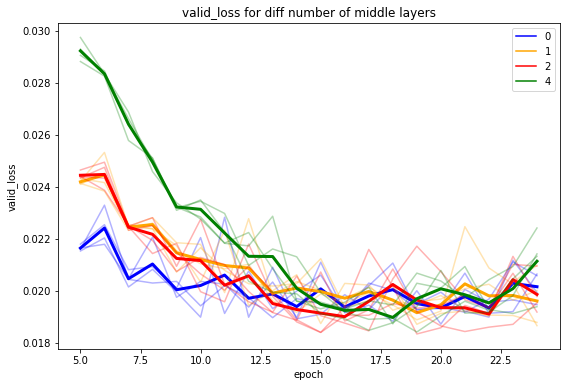

In [154]:
MIDDLE_LAYERS = (0,1,2,4)
TRIALS        = 4

metric_name = 'valid_loss'
start_ind = 5
b_mean = True

plt.figure(figsize=(9,6))
d_legend = {0:'blue', 1:'orange', 2:'red', 4:'green'}

for num_layers in MIDDLE_LAYERS:
    mean_tmp = pd.DataFrame()
    for trial in range(TRIALS):
        series = d_history[(num_layers, trial)][metric_name]
        series = series[start_ind:]
        mean_tmp = pd.concat((mean_tmp, series), axis=1)
        plt.plot(series, c=d_legend[num_layers], alpha=0.3)
    if b_mean: 
        mean_series = mean_tmp.apply(np.mean, axis=1)
        plt.plot(mean_series, c=d_legend[num_layers], linewidth=3)

plt.ylabel(metric_name)
plt.xlabel('epoch')
plt.legend([str(e) for e in d_legend.keys()])

handles = [mlines.Line2D([],[],c=color) 
           for color in d_legend.values() ]
plt.legend(handles, [str(e) for e in d_legend.keys()])

plt.title(f'{metric_name} for diff number of middle layers');

In [144]:
d_history[(0,0)].columns

Index(['epoch', 'train_loss', 'valid_loss', 'mae', 'r2_score', 'time'], dtype='object')

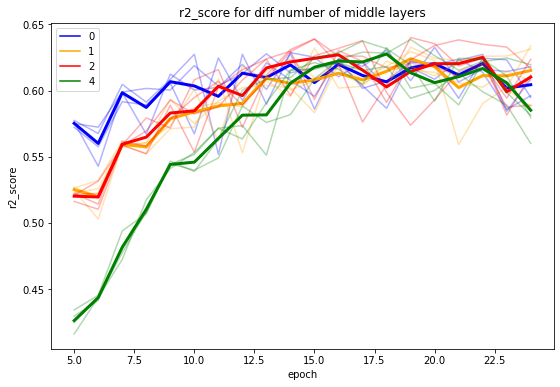

In [155]:
MIDDLE_LAYERS = (0,1,2,4)
TRIALS        = 4

metric_name = 'r2_score'
start_ind = 5
b_mean = True

plt.figure(figsize=(9,6))
d_legend = {0:'blue', 1:'orange', 2:'red', 4:'green'}

for num_layers in MIDDLE_LAYERS:
    mean_tmp = pd.DataFrame()
    for trial in range(TRIALS):
        series = d_history[(num_layers, trial)][metric_name]
        series = series[start_ind:]
        mean_tmp = pd.concat((mean_tmp, series), axis=1)
        plt.plot(series, c=d_legend[num_layers], alpha=0.3)
    if b_mean: 
        mean_series = mean_tmp.apply(np.mean, axis=1)
        plt.plot(mean_series, c=d_legend[num_layers], linewidth=3)

plt.ylabel(metric_name)
plt.xlabel('epoch')
plt.legend([str(e) for e in d_legend.keys()])

handles = [mlines.Line2D([],[],c=color) 
           for color in d_legend.values() ]
plt.legend(handles, [str(e) for e in d_legend.keys()])

plt.title(f'{metric_name} for diff number of middle layers');